In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import mlflow
import mlflow.pytorch
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

### Challenge:

- predizer o valor de fechamento da bolsa de valores de uma empresa 
- pipeline de desenvolvimento:
    - criação do modelo preditivo
    - deploy do modelo em uma API que permita a previsão de preços de ações

In [14]:
# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dados históricos:

- techfase4\process\get_data.ipynb
- tensorer não aceitam string nem datas

In [57]:
df = pd.read_pickle("dados.pkl")
df["Date"] = pd.to_datetime(df["Date"])
df["Timestamp"] = df["Date"].astype("int64") // 10**9  # segundos desde 1970
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["WeekDay"] = df["Date"].dt.weekday

In [58]:
df = df.sort_values("Date")
df = df.drop(columns=["Date"])

In [59]:
df.head()

,Close,High,Low,Open,Ticker,Volume,Timestamp,Year,Month,Day,WeekDay
0,137.391541,137.623750,136.444877,137.087896,ACN,3061900,1514851200,2018,1,2,1
1,138.025620,138.418577,136.632416,136.632416,ACN,2064200,1514937600,2018,1,3,2
2,139.659958,140.088633,138.222097,138.427502,ACN,1777000,1515024000,2018,1,4,3
3,140.812057,140.856714,139.436719,139.865394,ACN,1597600,1515110400,2018,1,5,4
4,141.937332,142.008780,140.070796,140.544128,ACN,2616900,1515369600,2018,1,8,0


### Inspecionando os dados para definição da janela temporal

In [60]:
df.describe()

,Close,High,Low,Open,Volume,Timestamp,Year,Month,Day,WeekDay
count,1873.000000,1873.000000,1873.000000,1873.000000,1.873000e+03,1.873000e+03,1873.000000,1873.000000,1873.000000,1873.000000
mean,249.629985,251.959652,247.217214,249.504800,2.300837e+06,1.632194e+09,2021.237587,6.347571,15.695141,2.026161
std,74.149978,74.860414,73.489809,74.147875,1.082340e+06,6.785369e+07,2.158920,3.434579,8.764150,1.399733
min,121.532257,124.487145,120.586675,122.559629,5.281000e+05,1.514851e+09,2018.000000,1.000000,1.000000,0.000000
25%,174.650208,176.011583,173.041359,174.291186,1.652200e+06,1.573430e+09,2019.000000,3.000000,8.000000,1.000000
50%,265.695068,268.057948,262.927262,264.879462,2.054600e+06,1.632182e+09,2021.000000,6.000000,16.000000,2.000000
75%,308.175201,311.455574,305.912421,308.221585,2.590400e+06,1.690934e+09,2023.000000,9.000000,23.000000,3.000000
max,396.284912,396.384425,391.758116,394.201428,1.490550e+07,1.749773e+09,2025.000000,12.000000,31.000000,4.000000


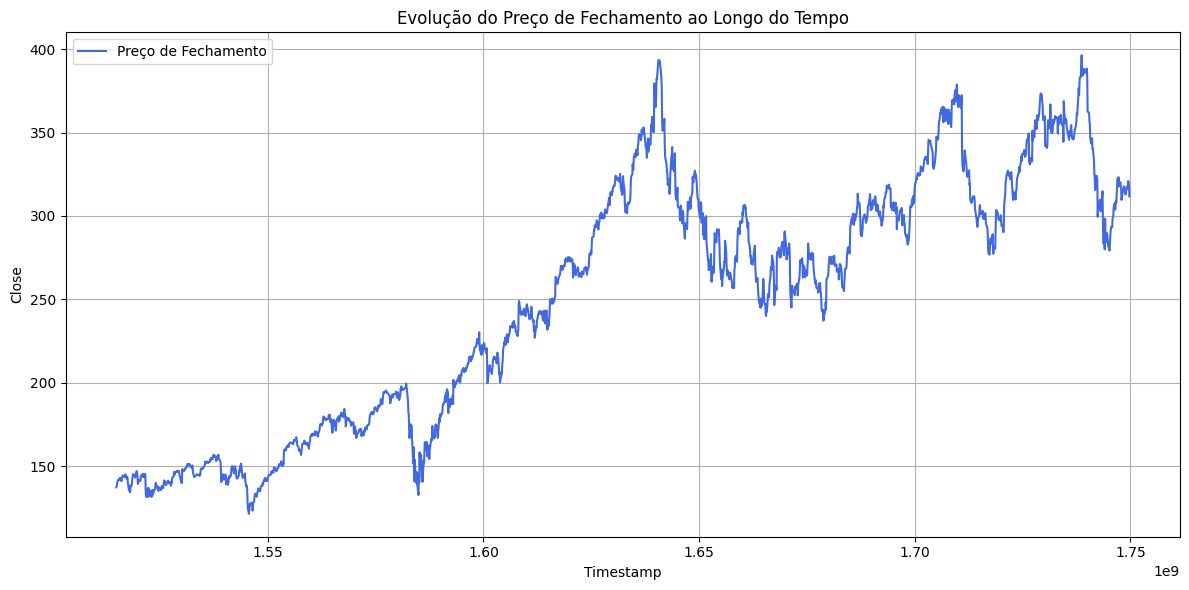

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(df["Timestamp"], df["Close"], label="Preço de Fechamento", color="royalblue")
plt.xlabel("Timestamp")
plt.ylabel("Close")
plt.title("Evolução do Preço de Fechamento ao Longo do Tempo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Normalização dos dados

1. Coluna Ticker, categórica, converter para numérica

In [62]:
df["Ticker"] = LabelEncoder().fit_transform(df["Ticker"])
tickers = df["Ticker"]

2. Colunas numéricas

In [63]:
df_num = df.drop(columns=["Ticker"], errors="ignore")

df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df_num), columns=df_num.columns)

In [64]:

# Reanexa a coluna Ticker
df_scaled["Ticker"] = tickers.values

In [68]:
df_scaled

,Close,High,Low,Open,Volume,Timestamp,Year,Month,Day,WeekDay,Ticker
0,0.057722,0.048315,0.058480,0.053483,0.176235,0.000000,0.0,0.000000,0.033333,0.25,0
1,0.060030,0.051238,0.059172,0.051806,0.106841,0.000368,0.0,0.000000,0.066667,0.50,0
2,0.065978,0.057380,0.065034,0.058415,0.086865,0.000736,0.0,0.000000,0.100000,0.75,0
3,0.070171,0.060205,0.069513,0.063708,0.074388,0.001103,0.0,0.000000,0.133333,1.00,0
4,0.074267,0.064442,0.071852,0.066207,0.145284,0.002207,0.0,0.000000,0.233333,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...
1868,0.710049,0.716237,0.720774,0.719515,0.122637,0.998529,1.0,0.454545,0.266667,0.00,0
1869,0.725699,0.725284,0.724314,0.717895,0.127144,0.998897,1.0,0.454545,0.300000,0.25,0
1870,0.719512,0.725579,0.727412,0.730228,0.092569,0.999264,1.0,0.454545,0.333333,0.50,0
1871,0.715544,0.713993,0.721032,0.717638,0.115904,0.999632,1.0,0.454545,0.366667,0.75,0


### Criando sequências para LSTM

In [69]:
data = df_scaled.to_numpy()

In [71]:
def create_sequences(data, sequence_length, target_index):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length][target_index])
    return np.array(X), np.array(y)

# Exemplo de uso:
target_index = df_scaled.columns.get_loc("Close")
data_array = df_scaled.drop(columns=["Ticker"], errors="ignore").to_numpy()
X_seq, y_seq = create_sequences(data_array, 20, target_index)

### Convertendo para tensores e DataLoader

In [72]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

### LSTM

In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.lstm(x)  # output: (batch, seq_len, hidden)
        last_output = output[:, -1, :]  # pega o último passo da sequência
        out = self.fc(last_output)
        return out

In [ ]:
# Hyperparameters
input_size = 10      # Number of features in the input data
hidden_size = 50     # Number of hidden units in the LSTM
num_layers = 2       # Number of LSTM layers
output_size = 1      # Number of output units (e.g., regression output)
num_epochs = 50
batch_size = 64
learning_rate = 0.001
sequence_length = 20  # Length of the input sequences
num_samples = 10000  # Number of artificial samples to generate